# Question 4

We consider an inversion problem where we are trying to find the location of the release of a pollutant that we know has been released some time $T$ ago from the south coast of a lake; We just don't know exactly where along the coast. The spread of the pollutant can be described by the following PDE

$$
\frac{\partial c(x,y,t)}{\partial t} = \kappa \nabla^2 c(x,y,t),
$$

where $c(x,y,t)$ is the concentration of the pollutant at $(x,y)$ at time $t$, and $\kappa$ is the diffusion coefficient.

For the discretisation (which you don't need to know the details of) we use the following implicit Euler time-stepping scheme

$$
  \frac{{\bf c}^{k+1} - {\bf c}^k}{\Delta t} = -\frac{\kappa}{\Delta x^2} \underline{\mathbf A} {\bf c}
$$

where $\bf c^k$ is the $n$-vector containing the discrete solution at all $n$ grid points at timestep $k$, and $\underline{\mathbf A}$ is the $n\times n$ matrix associated with the finite-difference discretisation of the Laplace operator $-\nabla^2$, for which you can use the code given below. Using the $n\times n$ identity operator $\underline{\mathbf I}$, we can write this as

\begin{equation}
  \left(\underline{\mathbf I} + \kappa \frac{\Delta t}{\Delta x^2} \underline{\mathbf A}\right) {\bf c}^{k+1}
  = {\bf c}^k \tag{1}
\end{equation}

which gives a linear system to be solved in every time-step.

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import scipy.optimize as sop
import matplotlib.pyplot as plt

def Laplace(Nx, Ny):
    """ Assembles a discrete Laplace operator with Neumann boundary conditions
    into a sparse matrix.
    """
    # construct matrix from 5 (off-)diagonals
    # we provide the diagonals as one 5 x n array
    # the actual off-diagonals should of course be shorter
    # but dia_matrix cuts them off for us
    n = Nx*Ny
    offsets = [-Nx, -1, 0, 1, Nx]
    diags = -np.ones((5,n))
    diags[2] = -diags[2]*4  # main diagonal should be positive and 4 times the off-diagonals
    A = sp.dia_matrix((diags, offsets), shape=(n,n)).tocsr()
    
    # grid point in the right-most column, should not be connected to
    # the grid point in the first column on the next row
    for i in range(1,Ny):
        A[i*Nx-1, i*Nx] = 0
        A[i*Nx, i*Nx-1] = 0
        
    # for homogenous Neumann boundary conditions all we have to do is
    # make sure that the diagonal is set such that the row sum is zero
    # This replaces some of the 4 values on the diagonal with the actual number
    # of connected grid points on the boundary:
    A.setdiag(A.diagonal() - np.array(A.sum(axis=1)).flatten())
    
    return A

**4.1** Given the fact that $\underline{\mathbf A}$ is _symmetric_ and _positive semi-definite_, what do you know about the matrix $\underline{\mathbf I}+\kappa\frac{\Delta t}{\Delta x^2}\underline{\mathbf A}$ (assuming $\kappa, \Delta t, \Delta x$ are all strictly positive)? What solver strategy would you recommend?

## Solution <a class="tocSkip"></a>
You may in fact immediately use the fact that for a symmetric, positive semi-definite matrix 
$\underline{\mathbf A}$ and a strictly positive scalar $\mu > 0$  $\underline{\mathbf I}+\mu\underline{\mathbf A}$ is Symmetric Positive Definite (SPD) as this was stated in the lecture notes. It is important however that you make a destinction here between, on the one hand, _symmetric and positive semi-definite_, and on the other hand, _symmetric positive definite_ (SPD).

To prove this (optional) you can either use the definition in terms of ${\bf v}^T\underline{\mathbf A}{\bf v}\geq 0$ for all nonzero vectors $\bf v$ for semi-definite matrices, and ${\bf v}^T\underline{\mathbf A}{\bf v}\gt 0$ for definite matrices. So that:

$$
{\bf v}^T\left(\underline{\mathbf I} + \kappa\frac{\Delta t}{\Delta x^2}\underline{\mathbf A}\right){\bf v} = \underset{\gt 0}{\underbrace{{\bf v}^T{\bf v}}} 
+ \underset{\geq 0}{\underbrace{\kappa\frac{\Delta t}{\Delta x^2}{\bf v}^T\underline{\mathbf A}{\bf v}}} \gt 0
$$

proofs that $\underline{\mathbf I} + \kappa\frac{\Delta t}{\Delta x^2}\underline{\mathbf A}$ is SPD. Or, using the fact that for symmetric matrices we can define semi-definite resp. definite matrices as having positive ($\lambda\geq 0$) resp. stricly positive eigenvalues ($\lambda\gt 0$), if $\lambda$ is an eigenvalue of $\underline{\mathbf A}$ with eigenvector $\bf v$, then $\bf v$ is also an eigenvector of $\underline{\mathbf I} + \kappa\frac{\Delta t}{\Delta x^2}\underline{\mathbf A}$

$$
  \underline{\mathbf A}{\bf v} = \lambda {\bf v} \implies
  \left(\underline{\mathbf I} + \kappa\frac{\Delta t}{\Delta x^2}\underline{\mathbf A}\right){\bf v} = {\bf v} + \kappa\frac{\Delta t}{\Delta x^2}\lambda{\bf v}
  = \left(1 + \kappa\frac{\Delta t}{\Delta x^2}\lambda\right){\bf v}
$$

and thus the eigenvalues of $\underline{\mathbf I} + \kappa\frac{\Delta t}{\Delta x^2}\underline{\mathbf A}$ are $1 + \kappa\frac{\Delta t}{\Delta x^2}\lambda$ and strictly positive because $\lambda\geq 0$, thus proving that $\underline{\mathbf I} + \kappa\frac{\Delta t}{\Delta x^2}\underline{\mathbf A}$ is SPD.

The obvious choice to solve a linear system based on a sparse, symmetric positive definite matrix is of course the Conjugate Gradient method. A direct method may also be fine for the size of problem we are dealing with here.

-----------------------------------

We assume a square lake of $L$ by $W$, and a grid of $n=N_x \times N_y$. You may use the following parameter choices:

In [3]:
# number of grid points in both directions, and total number of gridpoints
Nx = 50
Ny = 50
n = Nx*Ny

L = 2e3  # length in x-direction
dx = L/(Nx-1)  # grid spacing - assumed to be the same in both directions
# NOTE: there was a bug in the distributed version of the assessment,
# which had W = L*Ny. Luckily this only affects the scaling on the y-axis
# in the plots. Below is the correct formula for W:
W = (Ny-1) * dx  # width in y-direction

dt = 3600  # timestep size
T = 3600*24  # total run time
Nt = int(T/dt)  # number of timesteps

kappa = 1  # diffusion coefficient

A = Laplace(Nx, Nx)
I = sp.eye(n)  # sparse n x n identity matrix
matrix = I + kappa*(dt/dx**2)*A

We want to study the effect of releasing the pollutant at $t=0$ in a single point somewhere along the south coast. We number the computational grid row by row, starting at the south coast at $y=0$, so the south coast itself corresponds to the first $N_x$ grid points. We will store the initial concentrations along the south coast in a length $N_x$ vector $m$. So you should initialise your model as follows:

In [4]:
m_init = np.zeros(Nx)  # initial concentrations along the south coast

# assume a release at a single grid point at e.g. x = 0.3 * L
m_init[int((0.3*L)/dx)] = 1

# set initial condition for c which is defined on the grid
c0 = np.zeros(n)
c0[:Nx] = m_init

You can plot any solution, or here the initial condition, as follows:

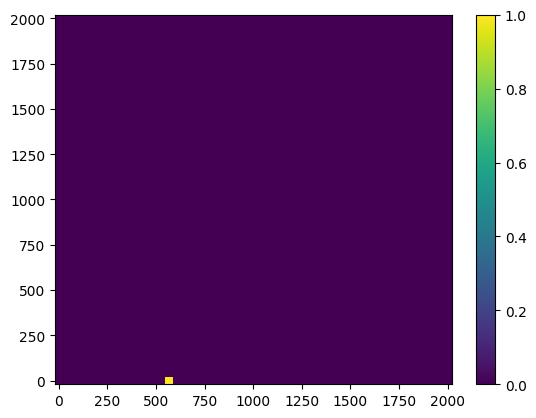

In [5]:
x = np.linspace(0, L, Nx)
y = np.linspace(0, W, Ny)

plt.pcolor(x, y, c0.reshape((Ny, Nx)))
plt.colorbar();

**4.2** Implement a time-stepping loop that performs `Nt` (defined above) timesteps, and plot the final solution at the end. Use the solver strategy you specified in the previous question. You may use any algorithm implemented in `scipy` here. Plot the final solution at time $t=T = N_t \Delta t = 1$ day.

## Solution <a class="tocSkip"></a>
We write the timestep loop as a function so we can reuse it later on:

In [11]:
def forward(source, Nt, matrix, cg_tol=1e-5):
    """
    Solve diffusion model for Nt timesteps
    """
    n = matrix.shape[1]
    Nx = len(source)
    
    # initial solution, with source copied into first Nx entries:
    rhs = np.zeros(n)
    rhs[:Nx] = source
    
    for i in range(Nt):
        # solve next timestep solution
        result = spl.cg(matrix, rhs, tol=cg_tol)
        # becomes old timestep solution on the rhs in the next iteration:
        rhs[:] = result[0]
    return result[0]

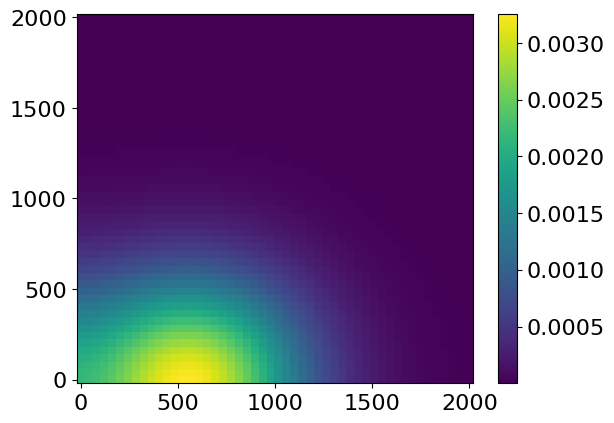

In [24]:
c_Nt = forward(m_init, Nt, matrix)

x = np.linspace(0, L, Nx)
y = np.linspace(0, W, Ny)

plt.pcolor(x, y, c_Nt.reshape((Ny, Nx)))
plt.colorbar();

c_target = c_Nt

----------------------

Store the final solution in a separate array `c_target`. We now like to see if we can retrieve the original `m_init` so that if we observe the spread of the pollutant in the form of `c_target`, we know where along the coast it was released some time `T = Nt * dt` ago. To do this we formulate the problem as a PDE-constrained optimisation problem:

$$
\text{minimize } f({\bf c}, {\bf m}) = \tfrac 12\| {\bf c}_{\text{target}} - {\bf c}^{N_t}\|^2
$$

subject to the _discrete_ PDE constraint

$$
\newcommand\bigm{\underline{\mathbf I} + \kappa\frac{\Delta t}{\Delta x^2} \underline{\mathbf A}}
\newcommand\idt{\underline{\mathbf I}}
{\bf g}({\bf c}, {\bf m}) =
\begin{pmatrix}
\vphantom{\begin{pmatrix}{\bf m} \\ 0 \end{pmatrix}} \idt & 0 & 0 & 0 & \dots & 0 & 0  \\
-\idt & \bigm & 0 & 0 & \dots & 0  & 0 \\
0 & -\idt & \bigm & 0 & \dots & 0  & 0\\
0 & 0 & -\idt & \bigm & \dots & 0  & 0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & \dots &  -\idt & \bigm & 0 \\
0 & 0 & 0 & 0 & \dots & -\idt & \bigm 
\end{pmatrix}
\begin{pmatrix}
  \vphantom\bigm {\bf c}^0 \\ \vphantom\bigm {\bf c}^1 \\ \vphantom\bigm{\bf c}^2 \\ \vphantom\bigm{\bf c}^3 \\ \vphantom\bigm\dots \\ \vphantom\bigm{\bf c}^{N_t-1} \\ \vphantom\bigm{\bf c}^{N_t}
\end{pmatrix}
-
\begin{pmatrix}
  \begin{pmatrix}{\bf m} \\ 0 \end{pmatrix} \\ \vphantom\bigm {\bf 0} \\ \vphantom\bigm{\bf 0} \\ \vphantom\bigm{\bf 0} \\ \vphantom\bigm\dots \\ \vphantom\bigm{\bf 0} \\ \vphantom\bigm{\bf 0}
\end{pmatrix} = 0
$$

Note that the first row of ${\bf g}({\bf c}, {\bf m})$:

$$
  \idt {\bf c}^0 - \begin{pmatrix}{\bf m} \\ 0 \end{pmatrix} = 0
  \quad\rightarrow\quad {\bf c}^0 = \begin{pmatrix}{\bf m} \\ 0 \end{pmatrix}
$$

simply represents the copying of the ${\bf m}$ vector of length $N_x$ into the first $N_x$ entries of ${\bf c}^0$, and zeroing the other entries. Subsequent rows represent the linear system of equations (given in eqn. (1) above question 4.1) of each time step.

We also define the associated reduced functional

$$\hat{f}({\bf m}) = f({\bf c}({\bf m}), {\bf m}),
\text{ where }{\bf c}({\bf m}) = {\bf c}
\text{ is the solution to }{\bf g}({\bf c}, {\bf m}) = 0,
$$

in other words we run the forward model using ${\bf m}$ to compute ${\bf c}$, and using its (final timestep) value compute $f$.

**4.3** Work out the adjoint equation for this discrete PDE-constrained optimisation problem, and describe how the adjoint solution vectors $\boldsymbol{\lambda}^{0}\dots \boldsymbol{\lambda}^{N_t}$ can be solved one-by-one. Work out the equations in terms of ${\bf c}_{target}$ and the solution vectors ${\bf c}^k$ of the forward model. Explain how we can compute $\frac{\partial\hat{f}({\bf m})}{\partial\bf m}$ after that.

## Solution <a class="tocSkip"></a>
The Lagrangian for the PDE-constrained optimisation problem is given by

$$
L({\bf c}, {\bf m}, \boldsymbol\lambda) = f({\bf c}, {\bf m}) - {\boldsymbol \lambda}^T {\bf g}({\bf c}, {\bf m})
$$

Note that here we are dealing with a time-dependent problem, so the constraints are formed by the discrete equations at each timestep, and thus $\boldsymbol\lambda$ has $(N_t+1) \times n$ entries (same as the number of equations) and we write $\boldsymbol\lambda = (\boldsymbol \lambda^0, \dots, \boldsymbol\lambda^{N_t})$ where each of the $\boldsymbol \lambda^i$ is a n-vector.

The adjoint equation comes from solving $\partial L/\partial {\bf c} = 0$ for $\boldsymbol\lambda$. Working out:

$$
\frac{\partial L({\bf c}, {\bf m}, \boldsymbol\lambda)}{\partial{\bf c}} = 
\frac{\partial f({\bf c}, {\bf m})}{\partial{\bf c}} -
{\boldsymbol \lambda}^T
\frac{\partial g({\bf c}, {\bf m})}{\partial{\bf c}} = 0
$$

which we can also write as

$$
\frac{\partial g({\bf c}, {\bf m})}{\partial{\bf c}}^T {\boldsymbol \lambda} =  \frac{\partial f({\bf c}, {\bf m})}{\partial{\bf c}}
$$

where $\frac{\partial g({\bf c}, {\bf m})}{\partial{\bf c}}$ is just the matrix in the definition of ${\bf g}({\bf c}, {\bf m})$ above. So taking the transpose we get

$$
\renewcommand\bigm{\underline{\mathbf I} + \kappa\frac{\Delta t}{\Delta x^2}
\underline{\mathbf A}}
\begin{pmatrix}
\vphantom{\begin{pmatrix}{\bf m} \\ 0 \end{pmatrix}} \idt & -\idt & 0 & 0 & \dots & 0 & 0  \\
0 & \bigm & -\idt & 0 & \dots & 0  & 0 \\
0 & 0 & \bigm & -\idt & \dots & 0  & 0\\
0 & 0 & 0 & \bigm & \dots & 0  & 0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & \dots &  0 & \bigm & -\idt \\
0 & 0 & 0 & 0 & \dots & 0 & \bigm 
\end{pmatrix}
\begin{pmatrix}
  \vphantom\bigm {\boldsymbol\lambda}^0 \\ \vphantom\bigm {\boldsymbol\lambda}^1 \\ \vphantom\bigm{\boldsymbol\lambda}^2 \\ \vphantom\bigm{\boldsymbol\lambda}^3 \\ \vphantom\bigm\dots \\ \vphantom\bigm{\boldsymbol\lambda}^{N_t-1} \\ \vphantom\bigm{\boldsymbol\lambda}^{N_t}
\end{pmatrix}
=
\begin{pmatrix}
  \frac{\partial f}{\partial{\bf c}^0} \\
  \frac{\partial f}{\partial{\bf c}^1} \\
  \frac{\partial f}{\partial{\bf c}^2} \\
  \frac{\partial f}{\partial{\bf c}^3} \\
  \vphantom\bigm\dots \\
  \frac{\partial f}{\partial{\bf c}^{N_t-1}} \\
  \frac{\partial f}{\partial{\bf c}^{N_t}}
\end{pmatrix}
$$

Here it is important to realize that $f$ only depends explicitly on ${\bf c}^{N_t}$ with

$$
\frac{\partial f}{\partial{\bf c}^{N_t}} = \left({\bf c}_{\text{target}} - {\bf c}^{N_t}\right)\cdot -1 = {\bf c}^{N_t} - {\bf c}_{\text{target}}
$$

and all other $\partial f/\partial c$ derivatives on the left-hand side of the adjoint equation are zero:

$$
\frac{\partial f}{\partial{\bf c}^i} = 0
\quad\text{ for all }i<N_t$$

We can now solve the adjoint equation by going backwards through the rows of the big-matrix version above. First solving:

$$
\left(\bigm\right) \boldsymbol\lambda^{N_t} = \frac{\partial f}{\partial{\bf c}^{N_t}} = {\bf c}^{N_t} - {\bf c}_{\text{target}}$$

followed by, solving subsequently:

$$
\left(\bigm\right) \boldsymbol\lambda^{N_t-1} = 
\boldsymbol\lambda^{N_t} + \frac{\partial f}{\partial{\bf c}^{N_t-1}} = \boldsymbol\lambda^{N_t} \\
\left(\bigm\right) \boldsymbol\lambda^{N_t-2} = 
\boldsymbol\lambda^{N_t-1} \\
\vdots \\
\left(\bigm\right) \boldsymbol\lambda^1 = 
\boldsymbol\lambda^2
$$

and finally $\boldsymbol\lambda^0=\boldsymbol\lambda^1$.

Finally we can compute $\frac{\partial\hat{f}({\bf m})}{\partial\bf m}$ using

$$
\frac{\partial\hat{f}({\bf m})}{\partial\bf m} = 
\frac{\partial L({\bf c}, {\bf m}, {\boldsymbol\lambda})}{\partial\bf m}
$$

As a reminder, this comes from the fact that if $\bf c({\bf m})$ is the solution of ${\bf g}({\bf c}({\bf m}), {\bf m})=0$, then we may write

$$
  \hat{f}({\bf m}) = f({\bf c}({\bf m}), {\bf m}) = L({\bf c}(\bf m), {\bf m},
  \boldsymbol\lambda)
$$

for arbitrary $\boldsymbol\lambda$ since ${\bf g}=0$, but then

$$\frac{\partial\hat{f}({\bf m})}{\partial\bf m} = 
\frac{L({\bf c}({\bf m}),{\bf m}),\boldsymbol\lambda)}{\partial\bf m} = 
\left.\frac{\partial L({\bf c},{\bf m},\boldsymbol\lambda)}{\partial\bf c}\right|_{{\bf c}={\bf c}({\bf m})}\frac{\partial{\bf c}({\bf m})}{\partial{\bf m}}
+
\left. \frac{\partial L({\bf c},{\bf m},\boldsymbol\lambda)}{\partial{\bf m}}
\right|_{{\bf c}={\bf c}({\bf m})}.
$$

So if we choose $\boldsymbol \lambda$ to be the solution to the adjoint equation $\frac{\partial L}{\partial{\bf c}}=0$, we're only left with the $\frac{\partial L}{\partial{\bf m}}$ term.

Working this out for our case

$$
\frac{\partial\hat{f}({\bf m})}{\partial\bf m} = 
\frac{\partial L({\bf c}, {\bf m}, {\bf\lambda})}{\partial\bf m}
=
\frac{\partial f({\bf c}, {\bf m})}{\partial\bf m}
-
\boldsymbol\lambda^T \frac{\partial{\bf g}({\bf c}, {\bf m})}{\partial\bf m},
$$

where $f$ does not explicitly depend on $\bf m$, so $\frac{\partial f}{\partial{\bf m}}=0$, and ${\bf g}$ only depends on $\bf m$ in the first row (row 0) ${\bf g}^0$ which gets multiplied with $\boldsymbol\lambda^0$.

$$
\frac{\partial\hat{f}({\bf m})}{\partial\bf m} = -{\boldsymbol\lambda^0}^T
\frac{\partial{\bf g}^0}{\partial{\bf m}}
$$

where

$$
{\bf g}^0({\bf c}, {\bf m}) = 
\underline{\mathbf I}_{n\times n}{\bf c}^0
-
\begin{pmatrix}
{\bf m} \\
{\bf 0}
\end{pmatrix}
=
\underline{\mathbf I}_{n\times n}{\bf c}^0
-
\begin{pmatrix}
\underline{\mathbf I}_{N_x\times N_x} \\
\underline{\mathbf 0}_{(n-N_x)\times N_x}
\end{pmatrix}
{\bf m}
$$

and thus

$$
\frac{\partial\hat{f}({\bf m})}{\partial\bf m} = -{\boldsymbol\lambda^0}^T
\frac{\partial{\bf g}^0}{\partial{\bf m}}
=
{\boldsymbol\lambda^0}^T 
\begin{pmatrix}
\underline{\mathbf I}_{N_x\times N_x} \\
\underline{\mathbf 0}_{(n-N_x)\times N_x}
\end{pmatrix}
= \begin{pmatrix} \lambda^0_1 \\ \lambda^0_2 \\ \vdots \\ \lambda^0_{N_x}
\end{pmatrix}
$$

i.e. a copy of the first $N_x$ entries of $\boldsymbol\lambda^0$.

-------------------------------------------------------------------------

**4.4** Implement the reduced functional `fhat(m)` which takes a length $N_x$ array `m`, runs the forward model and returns $f({\bf c}, {\bf m})$. Also implement its derivative `dfhat(m)` which takes a lenght $N_x$ array `m` and returns a length $N_x$ vector representing the gradient of $\hat{f}$ with respect to $\bf m$. Test your implementation for correctness! **Hint**: in the test of your derivative you may need to choose tighter tolerances in the solves that you use in the timesteps.

## Solution <a class="tocSkip"></a>
Implementing `fhat` is just combining the forward model from Q4.2 with the definition of `f(c, m)`. As suggested in the hint, we choose a tighter tolerance for the CG solve:

In [19]:
def f(c_Nt, m):
    return 0.5 * np.linalg.norm(c_target - c_Nt) **2

def fhat(m):
    c_Nt = forward(m, Nt, matrix, cg_tol=1e-9)
    return f(c_Nt, m)

In the previous questions we have layed out the sequence of solves to obtain the adjoint solution. As we saw above for the derivative we only need $\boldsymbol\lambda^0$, so we implement a function that only returns that part of $\boldsymbol\lambda$. As input we need the $\frac{\partial f}{\partial{\bf c}^{N_t}}$ for the right-hand side of the first solve:

In [34]:
def adjoint(dfdc_Nt, cg_tol=1e-5):
    rhs = dfdc_Nt
    for i in range(Nt):
        result = spl.cg(matrix, rhs, tol=cg_tol)
        rhs = result[0]
    # rhs now contains the result of the last solve, i.e. lambda^1
    # which is, as we saw above, the same as lambda^0
    return rhs

Note that you have to be quite careful to get the right number of solves in the adjoint, it basically has to be the same as the number of solves in the forward model. The adjoint model gives us what we need to implement `dfhat`. As it is a function of `m` and the adjoint depends on ${\bf c}^{N_t}$ which depends on $\bf m$, we need to run the forward model first to obtain ${\bf c}^{N_t}$ before calling the adjoint:

In [35]:
def dfhat(m):
    Nx = len(m)
    c_Nt = forward(m, Nt, matrix, cg_tol=1e-9)
    dfdc_Nt = c_Nt - c_target
    lambda_0 = adjoint(dfdc_Nt, cg_tol=1e-9)
    dfdm = lambda_0[0:Nx]
    return dfdm

It's also quite easy to make a sign error in either `dfdc_Nt` or in `lambda`. You may have started with a $+$ before $\boldsymbol\lambda$ in the definition of your Lagrangian (we used a $-$ above) in which case you should have ended up with `dfdm=-lambda_0` as the last step, if you have correctly worked through the equations with that sign convention. 

Luckily off-by-one errors (in counting the number of solves in the adjoint), and sign errors are easily caught if you properly test the derivative. This again should be done through a Taylor test. Here in particular it is important to carefully choose which point you evaluate the test in. We have constructed the optimisation problem in such a way that we actualy know the exact solution: the `c_target` we use is based on running the forward model with `m_init` we defined above. Therefore `m_init` is the solution to this inversion problem, which means that `dfhat` will be zero in that point. So if you test `dfhat` in this point only, you really only test that it's zero in this specific point, but if for instance you have made a sign error (or get the derivative wrong by some other scaling factor) that would not be picked up at all. Using a point `m` with all the same values (e.g. `np.ones(Nx)*np.random.random(1)`), or perturbation vector, also easily masks problems in your implementation.

Instead we again choose a completely random vector with values between 0 and 1. For the perturbation we choose random values between -0.01 and 0.01. Again using the Taylor test code from the lecture notes:

In [45]:
import numpy as np
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# scipy's optimization
import scipy.optimize as sop
import scipy.linalg as sl

# font sizes for plots
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']
def taylor_test(f, grad_f, x, h0, max_iter=8, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0.copy()
    residuals = []
    hnorms = []
    # these two stay the same, so we can compute them outside the loop:
    fx = f(x)
    dfdx = grad_f(x)
    
    for i in range(max_iter):
        if len(h.shape)>1:
            # tensordot sums over all indices of h and corresponding last indices of dfdx
            r = f(x + h) - fx - np.tensordot(dfdx, h, axes=len(h.shape))
        else:
            r = f(x + h) - fx - dfdx @ h
            
        residuals.append(sl.norm(r))
        hnorms.append(sl.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((5e-3, 1e-7), (2, 1), invert=True, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

We observe second order convergence below, which means we can be confident in our implementation of `dfhat`.

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[2.00000031 2.00000061 2.00000123 2.00000249 2.000005   2.00001037
 2.00002044]


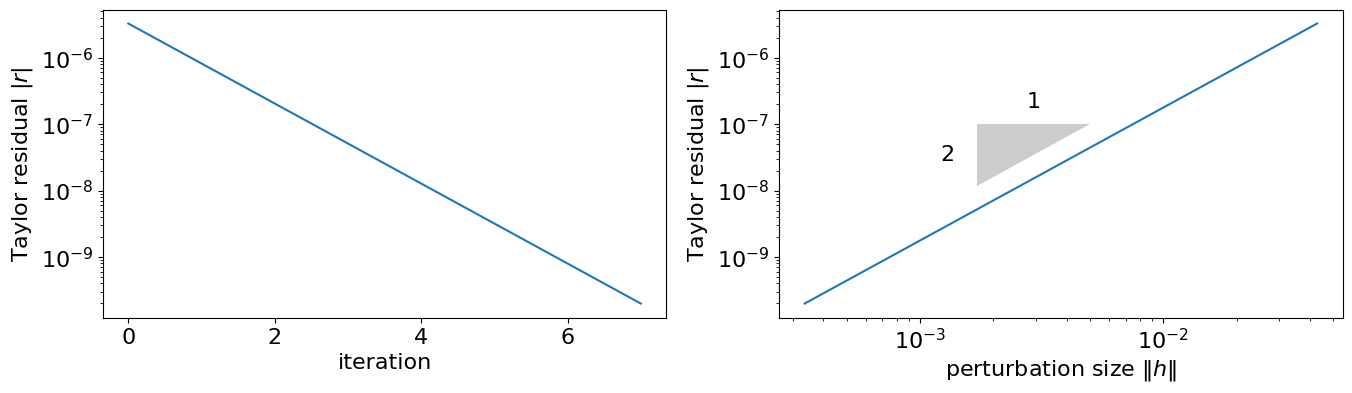

In [46]:
m = np.random.random(Nx)
h0 = np.random.random(Nx) * 0.02 - 0.01

taylor_test(fhat, dfhat, m, h0)

---------------------------------------

**4.5** Use `fhat` and `dfhat` to solve the inversion problem. You may use the following code, which enforces bounds to ensure that the resulting $\bf m$ stays between 0 and 1.

## Solution <a class="tocSkip"></a>
This is now merely a question of running the given code, which as predicted below show an inverted original source that is a lot wider than the one-point source, but is roughly in the right location:

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5.435278164597583e-07
        x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
      nit: 28
      jac: [ 2.384e-05  2.348e-05 ...  1.497e-05  1.486e-05]
     nfev: 32
     njev: 32
 hess_inv: <50x50 LbfgsInvHessProduct with dtype=float64>


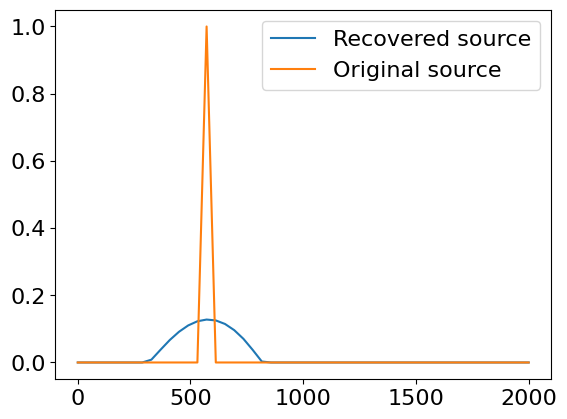

In [38]:
import scipy.optimize as sop
m = np.ones(Nx)
bounds = np.zeros((Nx, 2))
# lower bounds in the first column are zero
bounds[:,1] = 1  # upper bounds in the second column are one

result = sop.minimize(fhat, m, jac=dfhat, options={'maxiter':100, 'gtol': 1e-12}, method='l-bfgs-b', bounds=bounds)

print(result)
# this plots the recovered source vs. the original source
plt.plot(x, result['x'], label='Recovered source')
plt.plot(x, m_init, label='Original source')
plt.legend()

You may find that the recovered source is a spread out quite a bit more than the original $m$-vector. This is an example of an ill-posed problem: multiple vectors $\bf m$ may result in the same distribution of the concentration $c(x,y,t)$ after $N_t$ timesteps. Since we know that the original polution was very much concentrated in a single place we would like to penalize solutions that are more spread out. Note that our usual trick of penalising the norm of $\bf m$, does not work here: the solution `m` you find through the inversion process, will integrate to approximately the same value as the true source `m_init`, but the more spread out the smaller the norm will be; for example, if the true source has a value of 1 in just one grid point, but the recovered source has a value of $1/4$ in 4 grid points, then the norm of the recovered source is smaller: $\sqrt{{\tfrac 14}^2 + {\tfrac 14}^2 + {\tfrac 14}^2 + {\tfrac 14}^2}\lt 1$. So instead we want to do the reverse: penalise solutions with a small norm! This is possible here because the noisy oscillatory modes that would otherwise pollute the solution (and be encouraged by our penalty term!) are already kept in hand by the imposed bounds. Thus we want to change the functional to

$$
  f({\bf c}, {\bf m}) = \tfrac 12\| {\bf c}_{\text{target}} - {\bf c}^{N_t}\|^2 + \frac{\mu}{1 + \|{\bf m}\|^2},
$$

where $\mu$ is a user chosen parameter (suggested value $\mu=10^{-4}$).

**4.6** Extend the reduced functional, and its derivative, to include the new penalty term. Don't forget to test the derivative!

## Solution <a class="tocSkip"></a>
The additional term penalty term means that we also get an additional term in the derivative, because $f$ now also explicitly depends on $\bf m$:

$$
\frac{\partial\hat{f}({\bf m})}{\partial\bf m} = 
\begin{pmatrix} \lambda^0_1 \\ \lambda^0_2 \\ \vdots \\ \lambda^0_{N_x}
\end{pmatrix} + \frac{\partial f({\bf c},{\bf m})}{\partial{\bf m}}
=
\begin{pmatrix} \lambda^0_1 \\ \lambda^0_2 \\ \vdots \\ \lambda^0_{N_x}
\end{pmatrix}  - \frac{\mu}{(1+\|{\bf m}\|^2)^2}2{\bf m}
$$


To implement we define new versions of `f`, `fhat` and `dfhat`:

In [41]:
mu = 1e-4

def f_penalty(c_Nt, m):
    return 0.5 * np.linalg.norm(c_target - c_Nt) **2 + mu * 1/(1+np.dot(m, m))

def fhat_penalty(m):
    c_Nt = forward(m, Nt, matrix, cg_tol=1e-9)
    return f_penalty(c_Nt, m)

def dfhat_penalty(m):
    Nx = len(m)
    c_Nt = forward(m, Nt, matrix, cg_tol=1e-9)
    dfdc_Nt = c_Nt - c_target
    lambda_0 = adjoint(dfdc_Nt, cg_tol=1e-9)
    dfdm = lambda_0[0:Nx] - mu * 2 * m / (1+np.dot(m, m))**2
    return dfdm

Testing using the Taylor test again:

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.99999992 2.0000001  2.00000036 2.00000087 2.00000193 2.00000318
 2.00000574]


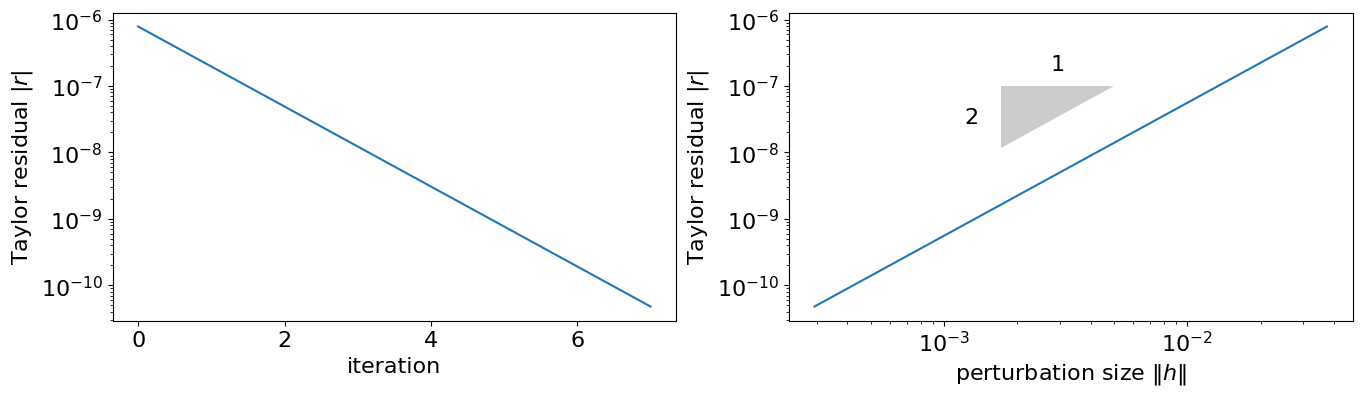

In [47]:
m = np.random.random(Nx)
h0 = np.random.random(Nx) * 0.02 - 0.01

taylor_test(fhat_penalty, dfhat_penalty, m, h0)

Now if we repeat the optimisation, we can exactly invert the original source:

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5.0000050271325584e-05
        x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
      nit: 68
      jac: [ 2.597e-07  2.610e-07 ...  1.768e-07  1.756e-07]
     nfev: 84
     njev: 84
 hess_inv: <50x50 LbfgsInvHessProduct with dtype=float64>


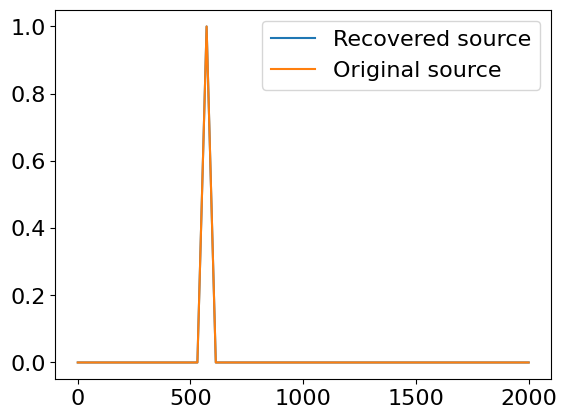

In [50]:
import scipy.optimize as sop
m = np.ones(Nx)
bounds = np.zeros((Nx, 2))
# lower bounds in the first column are zero
bounds[:,1] = 1  # upper bounds in the second column are one

result = sop.minimize(fhat_penalty, m, jac=dfhat_penalty, options={'maxiter':100, 'gtol': 1e-12}, method='l-bfgs-b', bounds=bounds)

print(result)
# this plots the recovered source vs. the original source
plt.plot(x, result['x'], label='Recovered source')
plt.plot(x, m_init, label='Original source')
plt.legend()